# Prophet Modelling Notebook

In [1]:
# basic imports
import pandas as pd
import numpy as np
import datetime as dt
import itertools

# metrics
from numpy import mean
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# import modules
from modules.time_series_functions import resample_series # (series, time_period='day', measure='revenue')
from modules.time_series_functions import create_date_features # (timeseries_df)
from modules.time_series_functions import add_lagged_features # (timeseries_df, num_lag)

# visualizations
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style='darkgrid', context='talk')

# time series
from prophet import Prophet
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# settings
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [2]:
# loading in dataset:
df = pd.read_csv(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\data\cleaned_data.csv', parse_dates=['date'])
df.head()

,order_id,date,item_code,quantity,unit_price,unit_cogs,country,item_name,style,name,group0,group1,group2,category,gender,age,sales_revenue,gross_profit,profit_margin,region
0,2000093388,2020-04-24,ZB00089178,1,5.829845,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.829845,3.620543,0.621036,Central Europe
1,1900182328,2019-11-04,ZB00089178,1,5.686483,0.000000,Slovakia,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,5.686483,5.686483,1.000000,Central Europe
2,1900186164,2019-11-10,ZB00089178,1,4.965116,2.373643,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.591473,0.521936,Central Europe
3,2000058563,2020-03-07,ZB00089178,1,4.965116,2.209302,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.965116,2.755814,0.555035,Central Europe
4,2000297106,2020-11-24,ZB00089178,1,4.772868,2.364341,Czech Republic,Team LIGA Socks CORE,70344113,Puma,Apparel,Socks,Football socks,football,unisex,adults,4.772868,2.408527,0.504629,Central Europe


In [3]:
df.shape

(1333384, 20)

## Daily Prophet Modelling (with data prep and feature engineering)

In [4]:
df_daily = resample_series(df, 'day', 'revenue')
df_daily.head()

,date,sales_revenue
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [5]:
df_daily.shape

(959, 2)

In [6]:
df_daily.head()

,date,sales_revenue
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [7]:
prophet_df_daily = df_daily.copy()

In [8]:
prophet_df_daily.head()

,date,sales_revenue
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [9]:
# rename the columns to 'ds' and 'y'
prophet_df_daily = prophet_df_daily.rename(columns={'date': 'ds', 'sales_revenue': 'y'})

In [10]:
prophet_df_daily.head()

,ds,y
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [11]:
# day of the week as a regressor in Prophet as additional feature:
prophet_df_daily['day_of_week'] = prophet_df_daily['ds'].dt.dayofweek

In [12]:
prophet_df_daily.head()

,ds,y,day_of_week
0,2019-06-01,4033.781335,5
1,2019-06-02,49.458527,6
2,2019-06-03,1323.282072,0
3,2019-06-04,68572.183865,1
4,2019-06-05,65144.273667,2


In [13]:
# create a Prophet model instance
model = Prophet(daily_seasonality=True)

# model.add_regressor('difference')
model.add_regressor('day_of_week')

# fit the model to the data
model.fit(prophet_df_daily)

18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:28:22 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# create a dataframe with future dates to make predictions for
future_dates = model.make_future_dataframe(periods=365)

# add day_of_week regressor to future dates
future_dates['day_of_week'] = future_dates['ds'].dt.dayofweek

# make predictions
forecast = model.predict(future_dates)

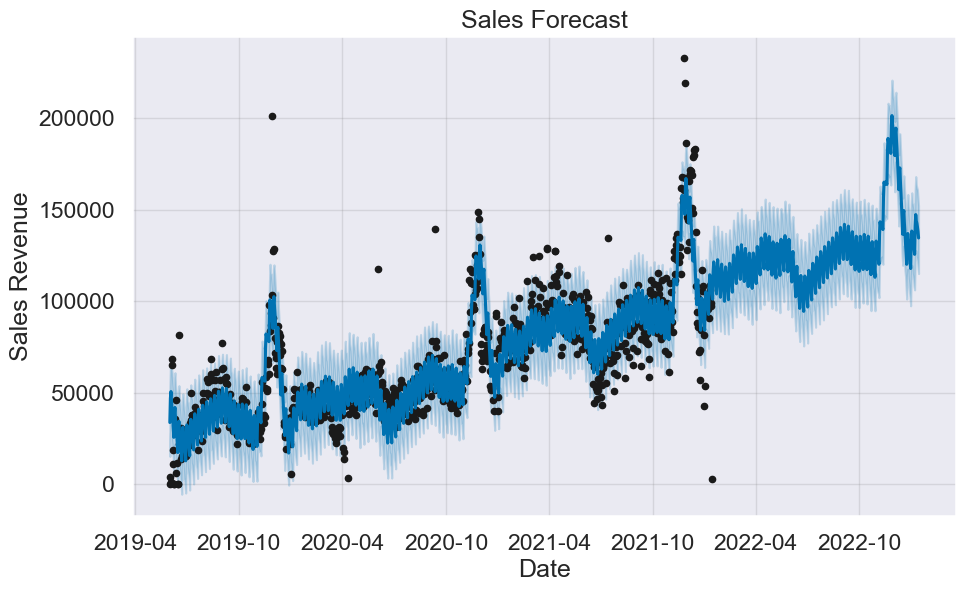

In [15]:
# plot the forecast
fig = model.plot(forecast)
plt.title('Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.show()

# plt.savefig(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\images/prophet_daily_forecast.png', dpi=300)

Based on the forecasted sales data, it appears that the business is poised for growth in the coming year. The positive trend indicates that sales revenue is expected to increase steadily, which could translate to higher profits and improved financial performance. The accounting department can use this information to plan budgets, forecast cash flows, and make strategic decisions about resource allocation. Additionally, the model's evaluation metrics suggest that it is performing well and making accurate predictions, providing further confidence in the forecasted results. Overall, this positive outlook should be encouraging for the business and could signal a successful future if the trend continues.

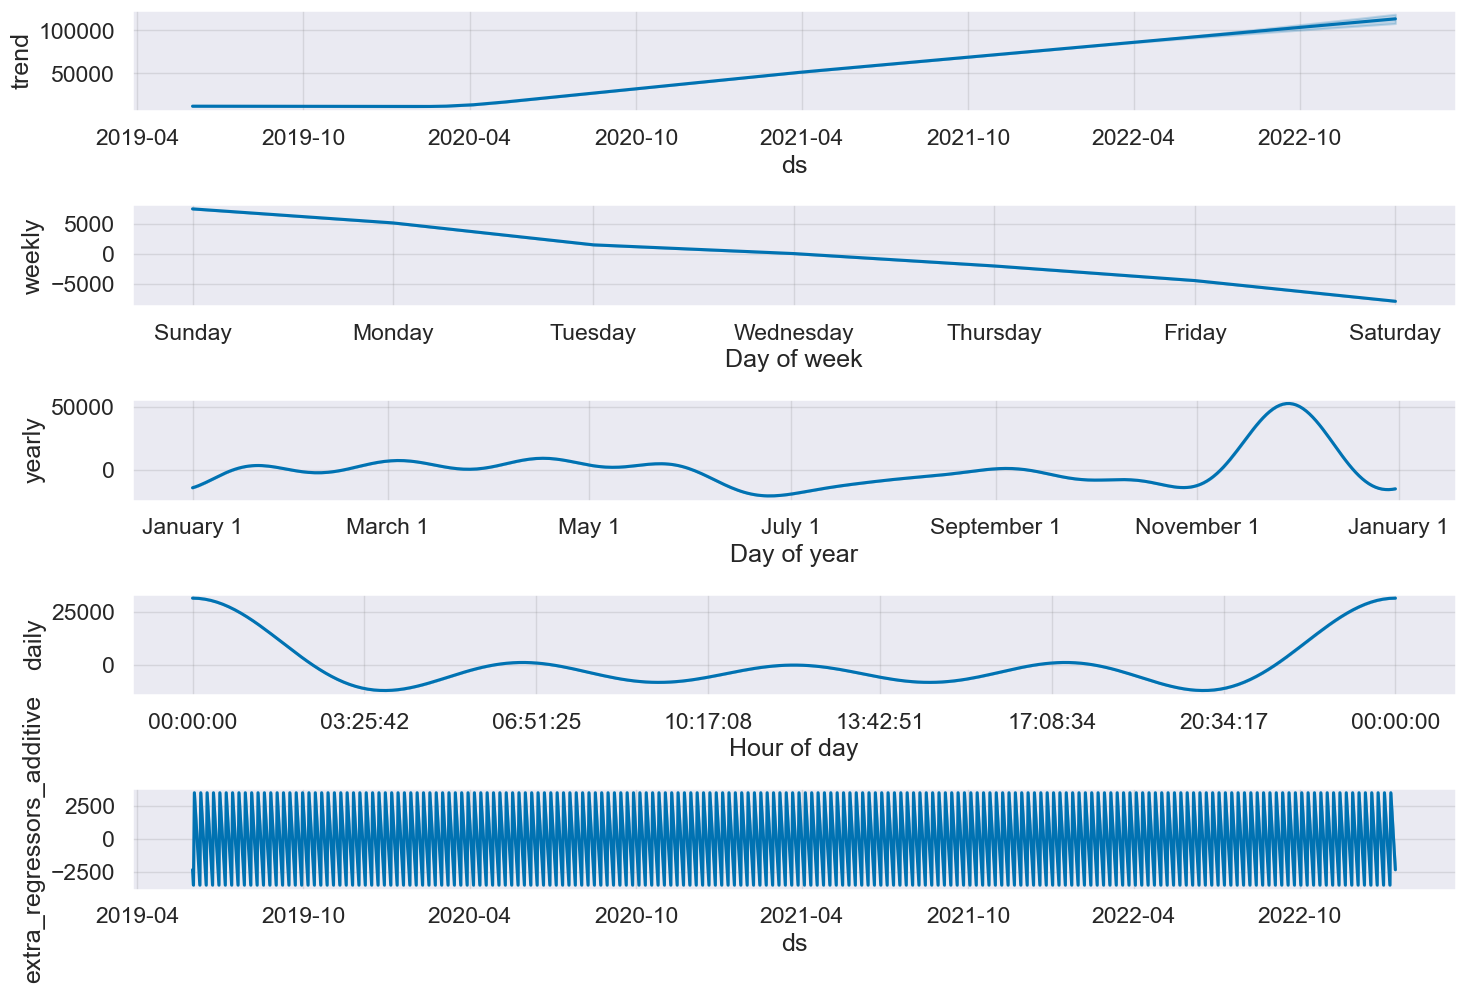

In [16]:
# ploting model components
fig = model.plot_components(forecast, figsize=(15, 10))
plt.show()

# plt.savefig(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\images/prophet_daily_trends.png', dpi=300)

In [17]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,11898.864022,15139.847405,52012.098407,11898.864022,11898.864022,21780.267662,21780.267662,21780.267662,31477.097252,...,-7895.150528,-7895.150528,-7895.150528,528.451182,528.451182,528.451182,0.0,0.0,0.0,33679.131684
1,2019-06-02,11897.254860,27630.587493,66002.948422,11897.254860,11897.254860,35079.819810,35079.819810,35079.819810,31477.097252,...,7538.534905,7538.534905,7538.534905,-440.616979,-440.616979,-440.616979,0.0,0.0,0.0,46977.074671
2,2019-06-03,11895.645699,32084.735725,68637.232499,11895.645699,11895.645699,38674.440141,38674.440141,38674.440141,31477.097252,...,5194.945870,5194.945870,5194.945870,-1492.798348,-1492.798348,-1492.798348,0.0,0.0,0.0,50570.085840
3,2019-06-04,11894.036538,24085.393562,62862.861222,11894.036538,11894.036538,32719.284529,32719.284529,32719.284529,31477.097252,...,1529.490819,1529.490819,1529.490819,-2617.433787,-2617.433787,-2617.433787,0.0,0.0,0.0,44613.321067
4,2019-06-05,11892.427376,21891.017017,60807.249670,11892.427376,11892.427376,28909.680673,28909.680673,28909.680673,31477.097252,...,70.035087,70.035087,70.035087,-3802.516788,-3802.516788,-3802.516788,0.0,0.0,0.0,40802.108049


In [18]:
# look at 'yhat', 'yhat_lower', and 'yhat_upper':
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,33679.131684,15139.847405,52012.098407
1,2019-06-02,46977.074671,27630.587493,66002.948422
2,2019-06-03,50570.085840,32084.735725,68637.232499
3,2019-06-04,44613.321067,24085.393562,62862.861222
4,2019-06-05,40802.108049,21891.017017,60807.249670


In [19]:
# look at 'yhat', 'yhat_lower', and 'yhat_upper':
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1319,2023-01-10,143817.436760,124451.741442,163543.564728
1320,2023-01-11,142510.598136,123478.667516,161964.025343
1321,2023-01-12,140522.676130,122064.362593,160966.717301
1322,2023-01-13,138073.233367,118674.614206,156280.979014
1323,2023-01-14,134506.228096,115045.601651,152222.736996


In [20]:
# find total predicted sales revenue sum so we can compare later to original sales revenue 

start_date = '2022-01-15'
end_date = '2023-01-14'

# filter dataframe for date range
forecast_filtered = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

# calculate sum of yhat column
total_sum_forecast = forecast_filtered['yhat'].sum()

print(f'The total sum of the yhat column from {start_date} to {end_date} is: {total_sum_forecast:.2f}')

The total sum of the yhat column from 2022-01-15 to 2023-01-14 is: 46545988.04


In [21]:
from sklearn.metrics import r2_score

y_true = prophet_df_daily['y']
y_pred = model.predict(prophet_df_daily)['yhat']

r2 = r2_score(y_true, y_pred)
print("R-squared score:", r2)

R-squared score: 0.7939672866501883


In [22]:
# rename the 'ds' column in the forecast dataframe to 'date'
forecast = forecast.rename(columns={'ds': 'date'})

# merge the forecast dataframe with df_daily on 'date'
forecast_daily_df = pd.merge(df_daily, forecast[['date', 'yhat']], on='date', how='left')

# rename the 'yhat' column to 'forecast_sales_revenue'
forecast_daily_df = forecast_daily_df.rename(columns={'yhat': 'forecast_sales_revenue'})

# print the merged dataframe
forecast_daily_df.head()

,date,sales_revenue,forecast_sales_revenue
0,2019-06-01,4033.781335,33679.131684
1,2019-06-02,49.458527,46977.074671
2,2019-06-03,1323.282072,50570.085840
3,2019-06-04,68572.183865,44613.321067
4,2019-06-05,65144.273667,40802.108049


In [23]:
forecast_daily_df.tail()

,date,sales_revenue,forecast_sales_revenue
954,2022-01-10,106185.035173,114392.095840
955,2022-01-11,108796.726653,110862.957397
956,2022-01-12,99231.427675,109463.259416
957,2022-01-13,97128.477211,107361.897334
958,2022-01-14,2915.216804,104781.967172


In [24]:
filtered_df = forecast_daily_df[(forecast_daily_df['date'] >= '2021-01-14') & (forecast_daily_df['date'] <= '2022-01-14')]

total_sales_revenue = filtered_df['sales_revenue'].sum()

print(total_sales_revenue)

34174710.597365


In [25]:
percentage_increase = ((total_sum_forecast - total_sales_revenue) / total_sales_revenue) * 100
print(f'The sales revenue increase year over year is: {percentage_increase:.2f}%')

The sales revenue increase year over year is: 36.20%


## Monthly Data Prophet Modelling 

In [26]:
df_monthly = resample_series(df, 'month', 'revenue')
df_monthly.head()

,date,sales_revenue
0,2019-06-30,6.383284e+05
1,2019-07-31,1.044891e+06
2,2019-08-31,1.476252e+06
3,2019-09-30,1.283833e+06
4,2019-10-31,1.054651e+06


In [27]:
prophet_df_monthly = df_monthly.copy()

In [28]:
# rename the columns to 'ds' and 'y'
prophet_df_monthly = prophet_df_monthly.rename(columns={'date': 'ds', 'sales_revenue': 'y'})

In [29]:
# day of the week as a regressor in Prophet as additional feature:
prophet_df_monthly['day_of_week'] = prophet_df_monthly['ds'].dt.dayofweek

In [30]:
prophet_df_monthly.head()

,ds,y,day_of_week
0,2019-06-30,6.383284e+05,6
1,2019-07-31,1.044891e+06,2
2,2019-08-31,1.476252e+06,5
3,2019-09-30,1.283833e+06,0
4,2019-10-31,1.054651e+06,3


In [31]:
# create a Prophet model instance
model = Prophet(daily_seasonality=True)

# model.add_regressor('difference')
model.add_regressor('day_of_week')

# fit the model to the data
model.fit(prophet_df_monthly)

18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:24 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# create a dataframe with future dates to make predictions for
future_dates = model.make_future_dataframe(periods=365)

# add day_of_week regressor to future dates
future_dates['day_of_week'] = future_dates['ds'].dt.dayofweek

# make predictions
forecast = model.predict(future_dates)

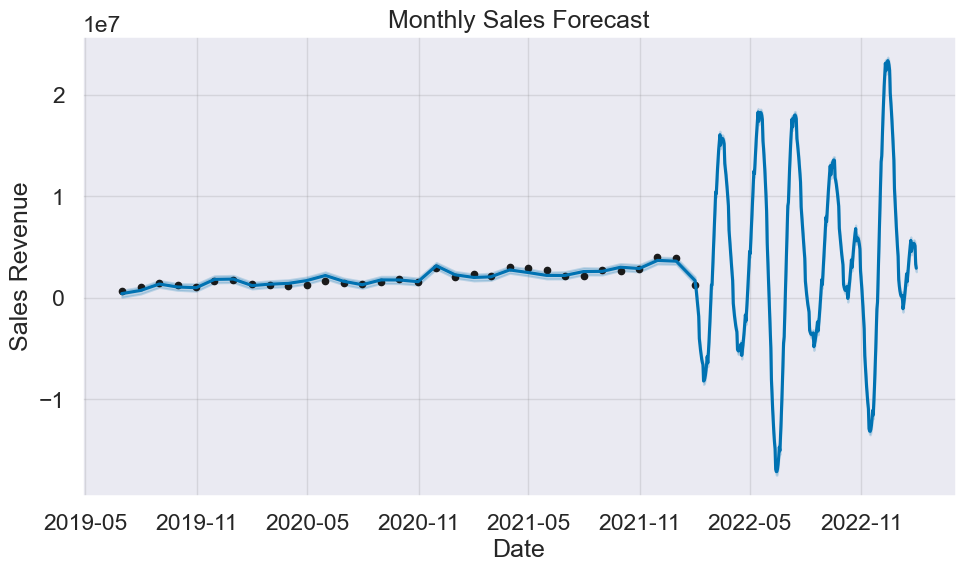

In [33]:
# plot the forecast
fig = model.plot(forecast)
plt.title('Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.show()

# plt.savefig(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\images/prophet_monthly_forecast.png', dpi=300)

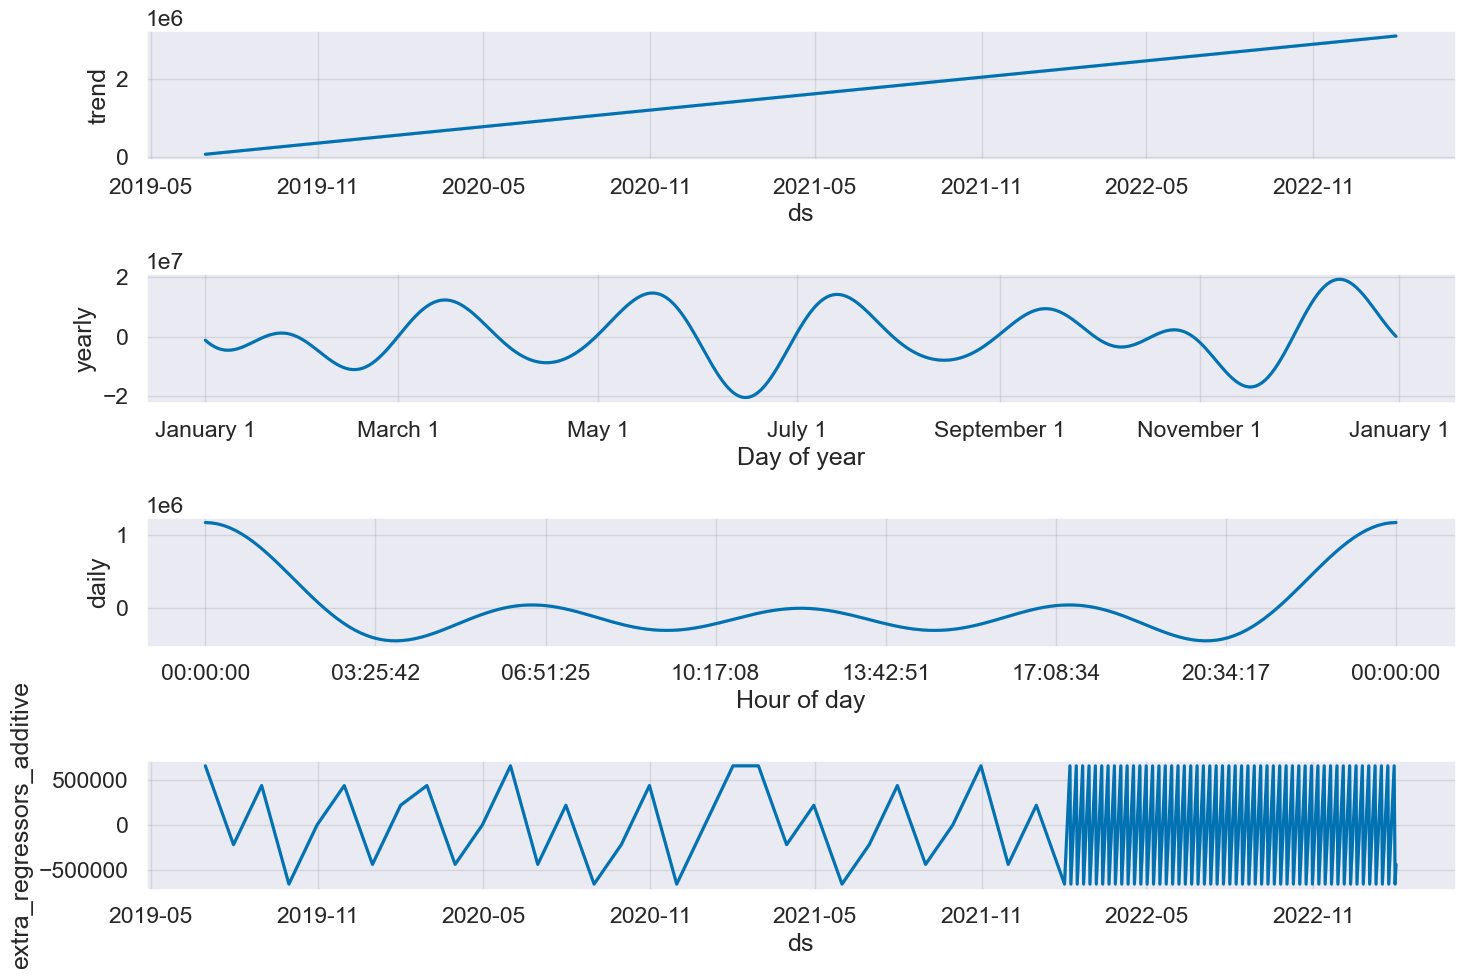

In [34]:
# ploting model components
fig = model.plot_components(forecast, figsize=(15, 10))
plt.show()

# plt.savefig(r'C:\Users\Jagvir Dhesi\lighthouselabs\projects\demand-prediction-project\images/prophet_monthly_trends.png', dpi=300)

In [35]:
# look at 'yhat', 'yhat_lower', and 'yhat_upper':
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-30,4.295235e+05,6.807242e+04,7.702080e+05
1,2019-07-31,7.401770e+05,3.796197e+05,1.074763e+06
2,2019-08-31,1.373505e+06,1.041542e+06,1.725241e+06
3,2019-09-30,1.081107e+06,7.522916e+05,1.418578e+06
4,2019-10-31,1.011772e+06,6.653229e+05,1.388146e+06


In [36]:
from sklearn.metrics import r2_score

y_true = prophet_df_monthly['y']
y_pred = model.predict(prophet_df_monthly)['yhat']

r2 = r2_score(y_true, y_pred)
print("R-squared score:", r2)

R-squared score: 0.8905685386990768


## Daily

In [37]:
df_monthly = resample_series(df, 'day', 'revenue')
df_monthly.head()

,date,sales_revenue
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [38]:
df_monthly.columns=['ds', 'y']
df_monthly.ds=pd.to_datetime(df_monthly['ds'])
df_monthly.sort_values('ds')
df_monthly.head()

,ds,y
0,2019-06-01,4033.781335
1,2019-06-02,49.458527
2,2019-06-03,1323.282072
3,2019-06-04,68572.183865
4,2019-06-05,65144.273667


In [39]:
train_df = df_monthly[:int(df_monthly.shape[0]*0.70)]

test_df = df_monthly[int(df_monthly.shape[0]*0.70):]

print(train_df.shape)
print(test_df.shape)

(719, 2)
(240, 2)


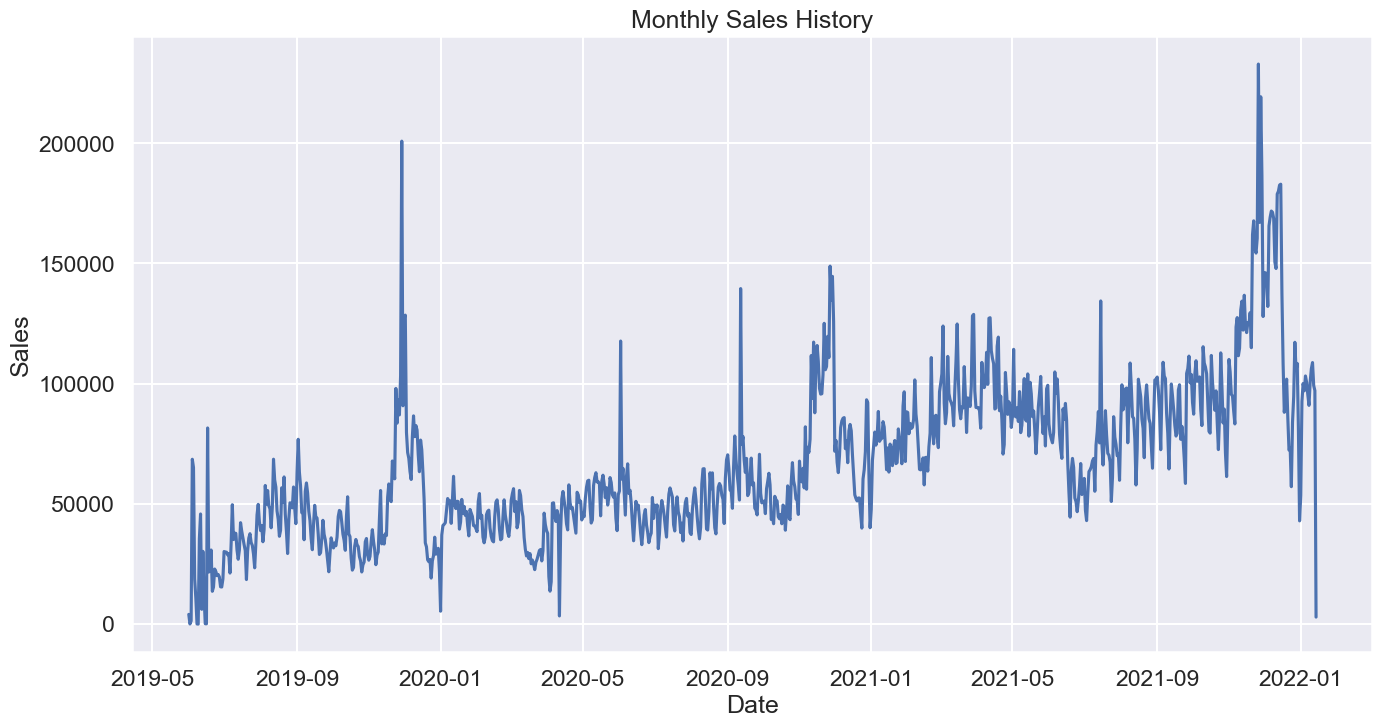

In [40]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', data=df_monthly, ax=ax)
ax.set(title='Monthly Sales History', ylabel='Sales', xlabel='Date');

In [41]:
# training the model on training set
model=Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=3)
model.add_seasonality(name='monthly', period=30, fourier_order=1)
model.fit(train_df)

18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing
18:28:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
future=model.make_future_dataframe(periods=12, freq='D')
forecast=model.predict(future)

In [43]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,30352.932078,-1409.933563,42388.082880,30352.932078,30352.932078,-9396.550699,-9396.550699,-9396.550699,-1276.287709,-1276.287709,-1276.287709,-8120.262990,-8120.262990,-8120.262990,0.0,0.0,0.0,20956.381379
1,2019-06-02,30441.436609,9593.113525,53937.918774,30441.436609,30441.436609,2493.065171,2493.065171,2493.065171,-896.606414,-896.606414,-896.606414,3389.671585,3389.671585,3389.671585,0.0,0.0,0.0,32934.501780
2,2019-06-03,30529.941141,16533.555721,58588.065044,30529.941141,30529.941141,6878.212299,6878.212299,6878.212299,-477.739116,-477.739116,-477.739116,7355.951415,7355.951415,7355.951415,0.0,0.0,0.0,37408.153439
3,2019-06-04,30618.445672,10909.236996,55254.051810,30618.445672,30618.445672,3109.087647,3109.087647,3109.087647,-37.992327,-37.992327,-37.992327,3147.079974,3147.079974,3147.079974,0.0,0.0,0.0,33727.533319
4,2019-06-05,30706.950203,11893.605192,52510.604403,30706.950203,30706.950203,1235.105849,1235.105849,1235.105849,403.414909,403.414909,403.414909,831.690939,831.690939,831.690939,0.0,0.0,0.0,31942.056052


In [44]:
# look at yhat, yhat_lower, and yhat_upper 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,20956.381379,-1409.933563,42388.082880
1,2019-06-02,32934.501780,9593.113525,53937.918774
2,2019-06-03,37408.153439,16533.555721,58588.065044
3,2019-06-04,33727.533319,10909.236996,55254.051810
4,2019-06-05,31942.056052,11893.605192,52510.604403


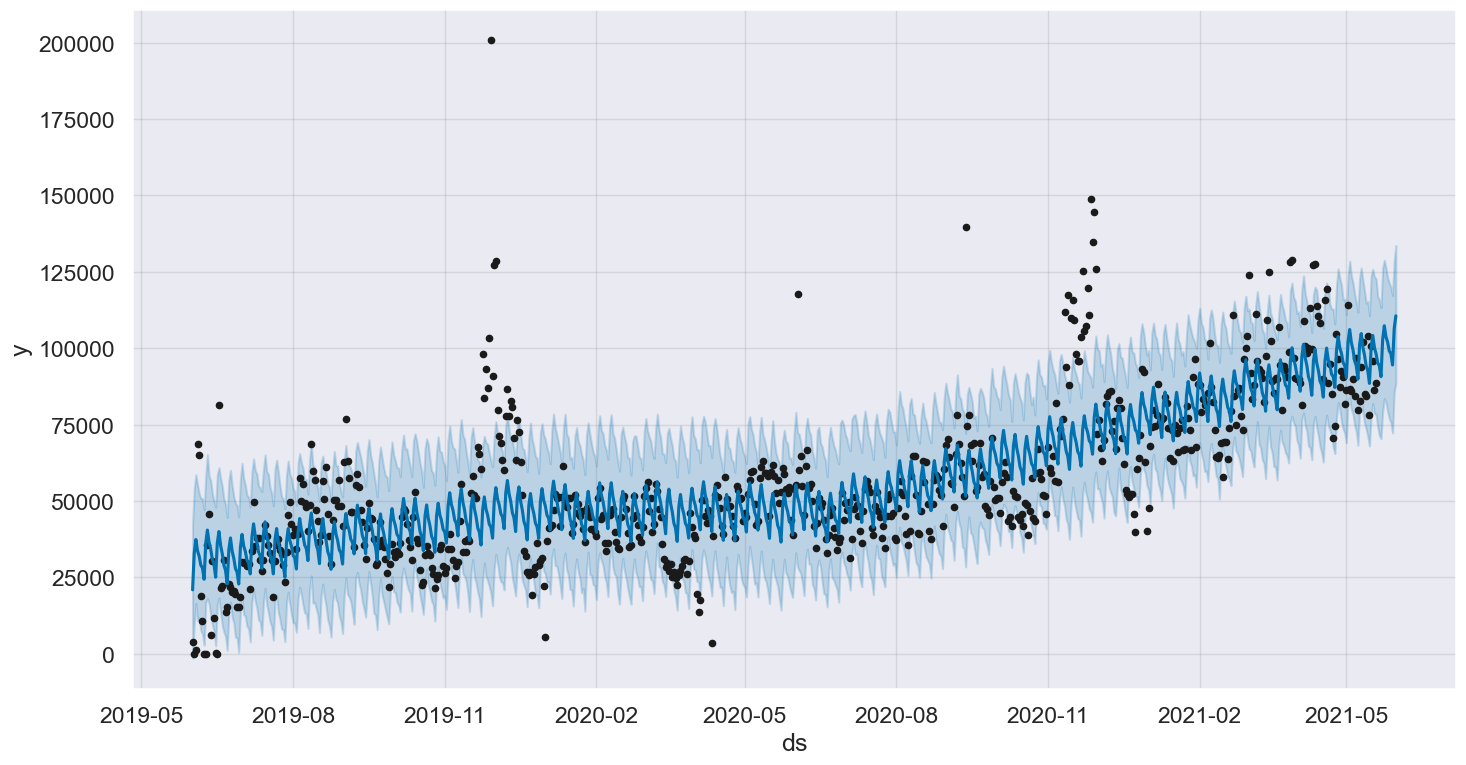

In [45]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

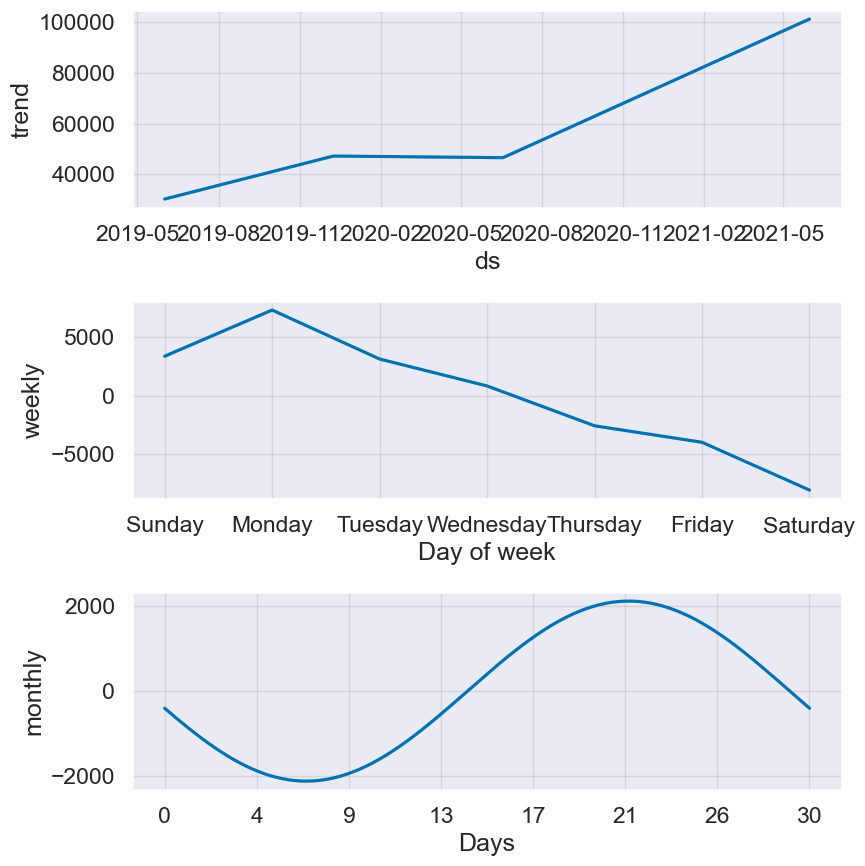

In [46]:
# ploting model components
model.plot_components(forecast)
plt.show()

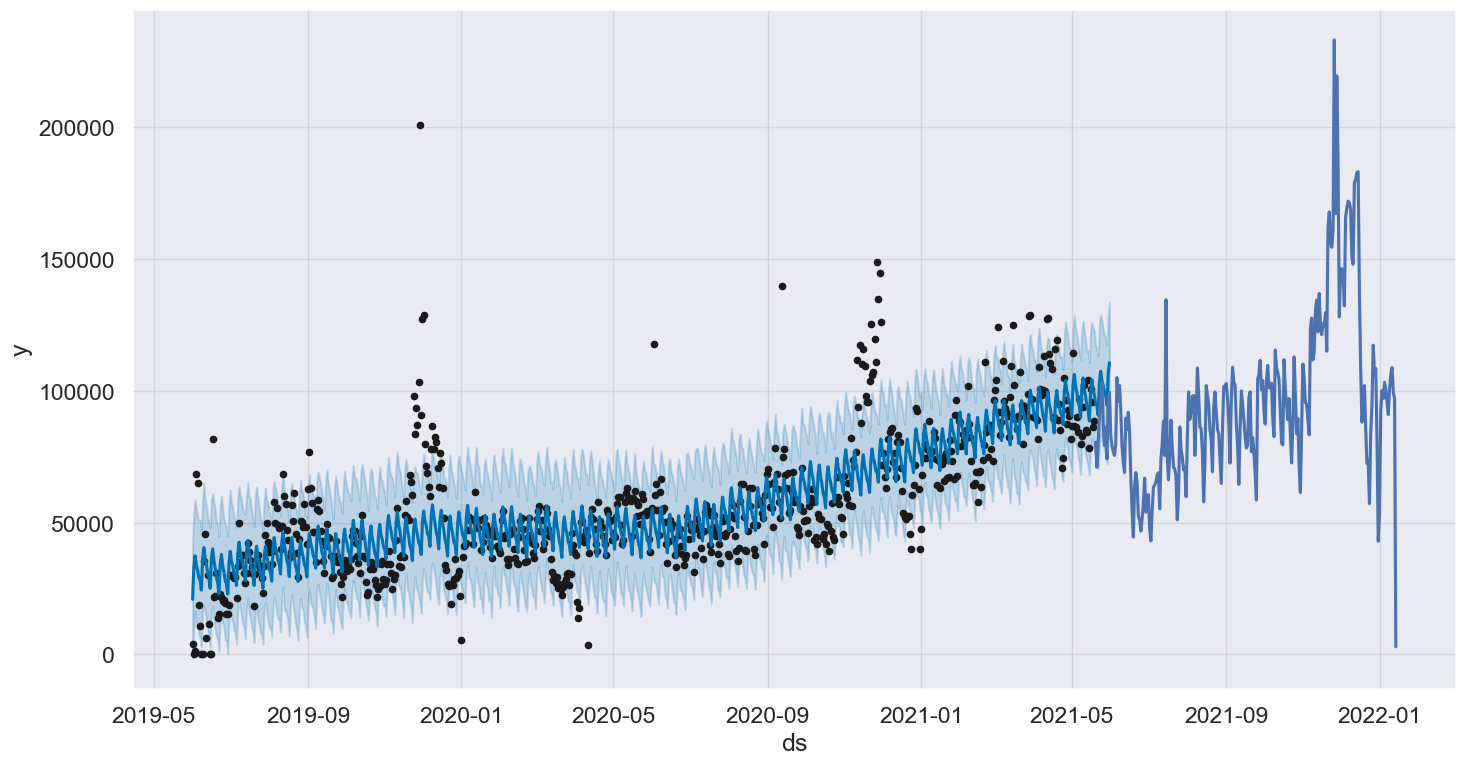

In [47]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)

ax.plot(test_df.ds, test_df.y)

Text(0.5, 1.0, 'One Month Forecast Vs Actual, Jan 1 to 30, 2021')

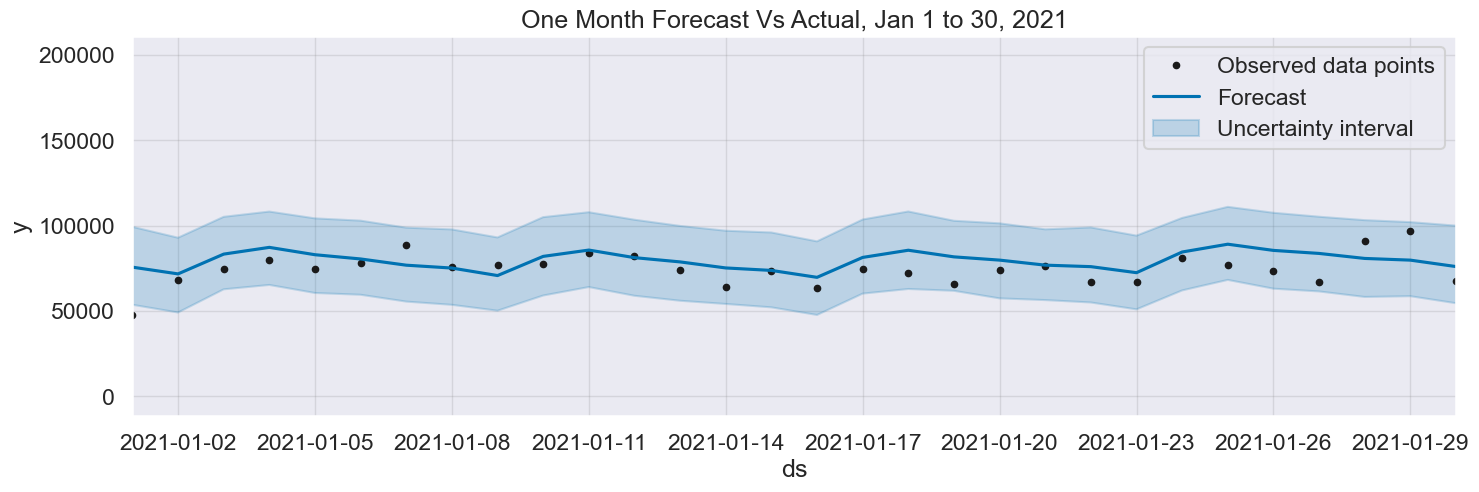

In [48]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-01-01', upper='2021-01-30')
plt.legend()
plt.title('One Month Forecast Vs Actual, Jan 1 to 30, 2021')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, Feb 1 to 28, 2021')

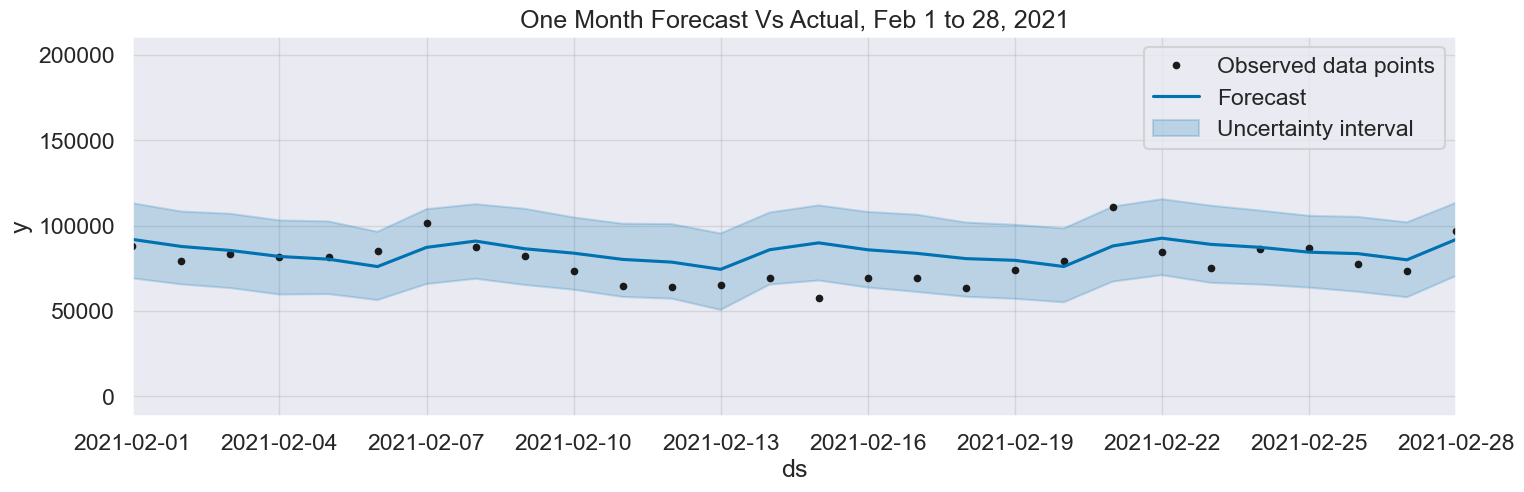

In [49]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-02-01', upper='2021-02-28')
plt.legend()
plt.title('One Month Forecast Vs Actual, Feb 1 to 28, 2021')

Text(0.5, 1.0, 'One Month Forecast Vs Actual, Mar 1 to 30, 2021')

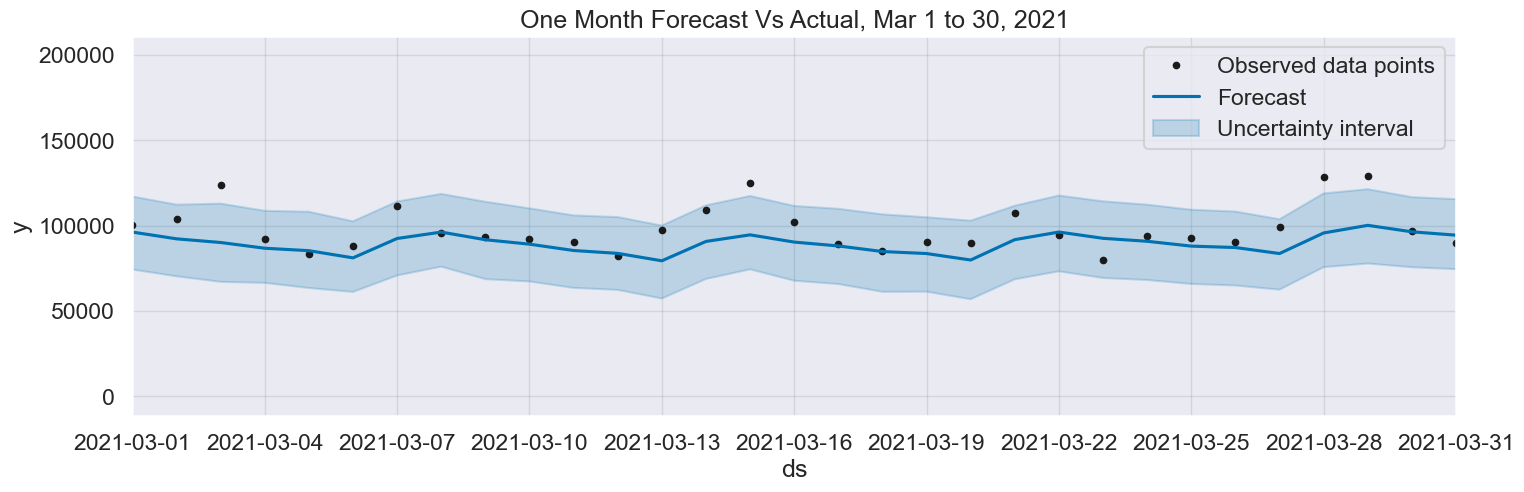

In [50]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-01', upper='2021-03-31')
plt.legend()
plt.title('One Month Forecast Vs Actual, Mar 1 to 30, 2021')

## Weekly

In [54]:
df_weekly = resample_series(df, 'week', 'revenue')
df_weekly.head()

,date,sales_revenue
0,2019-06-02,4083.239862
1,2019-06-09,164611.582140
2,2019-06-16,129654.622589
3,2019-06-23,208113.370792
4,2019-06-30,131865.611212


In [55]:
df_weekly.columns=['ds', 'y']
df_weekly.ds=pd.to_datetime(df_monthly['ds'])
df_weekly.sort_values('ds')
df_weekly.head()

,ds,y
0,2019-06-01,4083.239862
1,2019-06-02,164611.582140
2,2019-06-03,129654.622589
3,2019-06-04,208113.370792
4,2019-06-05,131865.611212


In [60]:
train_df = df_weekly[:int(df_weekly.shape[0]*0.70)]

test_df = df_weekly[int(df_weekly.shape[0]*0.70):]

print(train_df.shape)
print(test_df.shape)

(96, 2)
(42, 2)


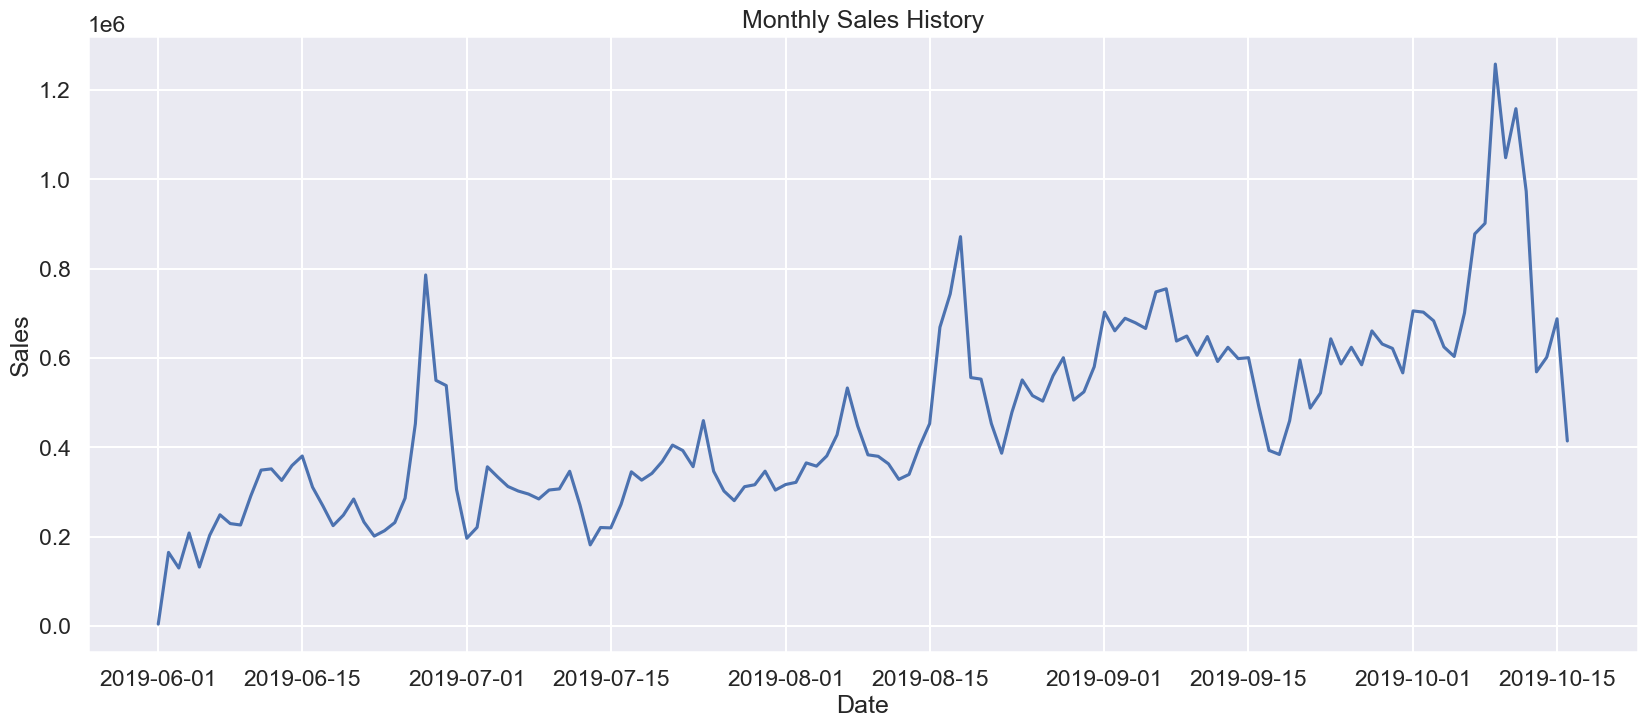

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x='ds', y='y', data=df_weekly, ax=ax)
ax.set(title='Monthly Sales History', ylabel='Sales', xlabel='Date');

In [62]:
# training the model on training set
from prophet.plot import add_changepoints_to_plot

model=Prophet(growth='linear',weekly_seasonality=False, daily_seasonality=False, changepoint_prior_scale=0.001)
model.add_seasonality( name='monthly', period=30.5, fourier_order=5)
model.fit(train_df)

19:43:25 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
future=model.make_future_dataframe(periods=test_df.shape[0]+5, freq='W')
forecast=model.predict(future)

In [64]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,197125.241771,3263.841111,268483.174349,197125.241771,197125.241771,-59362.426723,-59362.426723,-59362.426723,-59362.426723,-59362.426723,-59362.426723,0.0,0.0,0.0,137762.815048
1,2019-06-02,200878.287299,33604.994634,293487.695011,200878.287299,200878.287299,-36431.345389,-36431.345389,-36431.345389,-36431.345389,-36431.345389,-36431.345389,0.0,0.0,0.0,164446.941910
2,2019-06-03,204631.332827,73291.402549,327425.664640,204631.332827,204631.332827,-1371.750714,-1371.750714,-1371.750714,-1371.750714,-1371.750714,-1371.750714,0.0,0.0,0.0,203259.582113
3,2019-06-04,208384.378354,87568.973836,350958.008719,208384.378354,208384.378354,15901.283350,15901.283350,15901.283350,15901.283350,15901.283350,15901.283350,0.0,0.0,0.0,224285.661704
4,2019-06-05,212137.423882,88732.273020,340546.092068,212137.423882,212137.423882,5482.402920,5482.402920,5482.402920,5482.402920,5482.402920,5482.402920,0.0,0.0,0.0,217619.826802


In [65]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,137762.815048,3263.841111,268483.174349
1,2019-06-02,164446.941910,33604.994634,293487.695011
2,2019-06-03,203259.582113,73291.402549,327425.664640
3,2019-06-04,224285.661704,87568.973836,350958.008719
4,2019-06-05,217619.826802,88732.273020,340546.092068


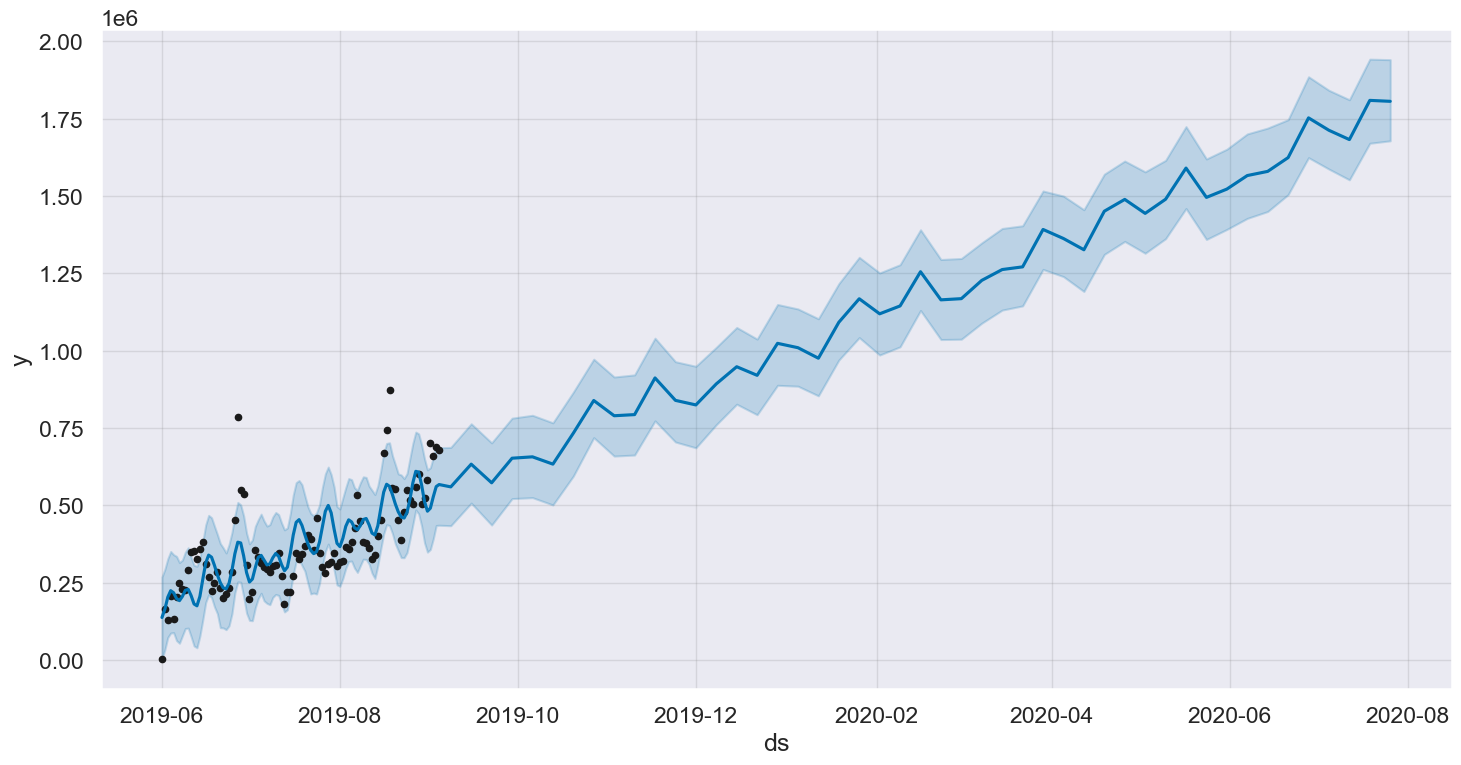

In [66]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

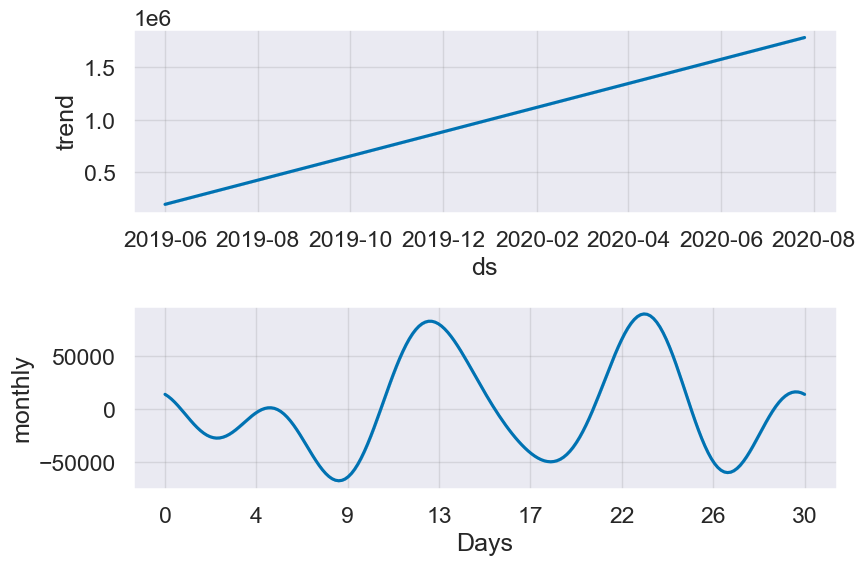

In [67]:
# ploting model components
model.plot_components(forecast)

plt.show()

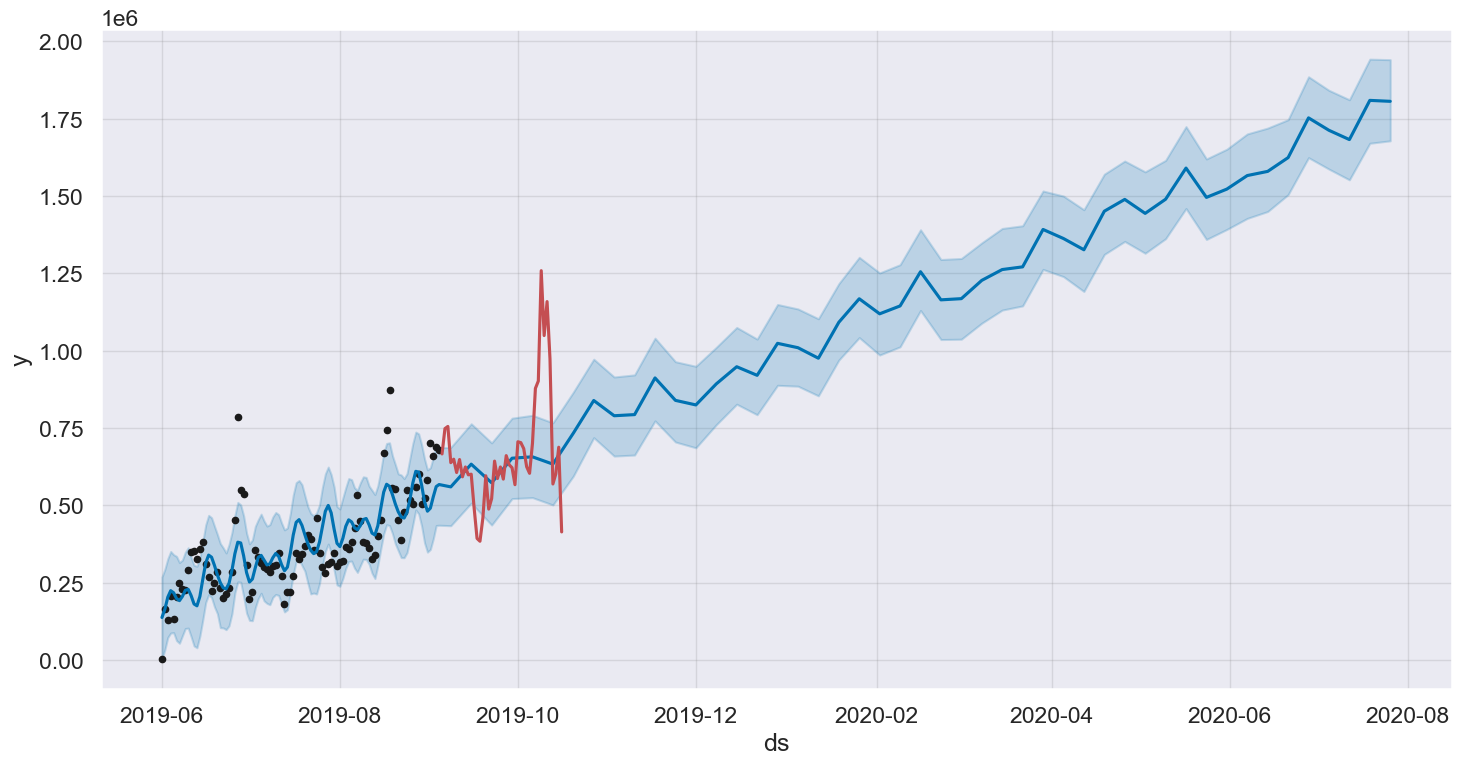

In [68]:
# comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r')

In [77]:
x_test_forecast=model.predict(test_df)
x_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-09-05,551586.529114,421820.413705,681081.338845
1,2019-09-06,536382.513423,408386.407253,663428.876627
2,2019-09-07,540258.678801,416062.235409,680876.423546
3,2019-09-08,559716.336995,436901.514535,689589.405292
4,2019-09-09,573506.955631,444203.394987,694744.709844


Text(0.5, 1.0, 'Forecast vs Actual Sales')

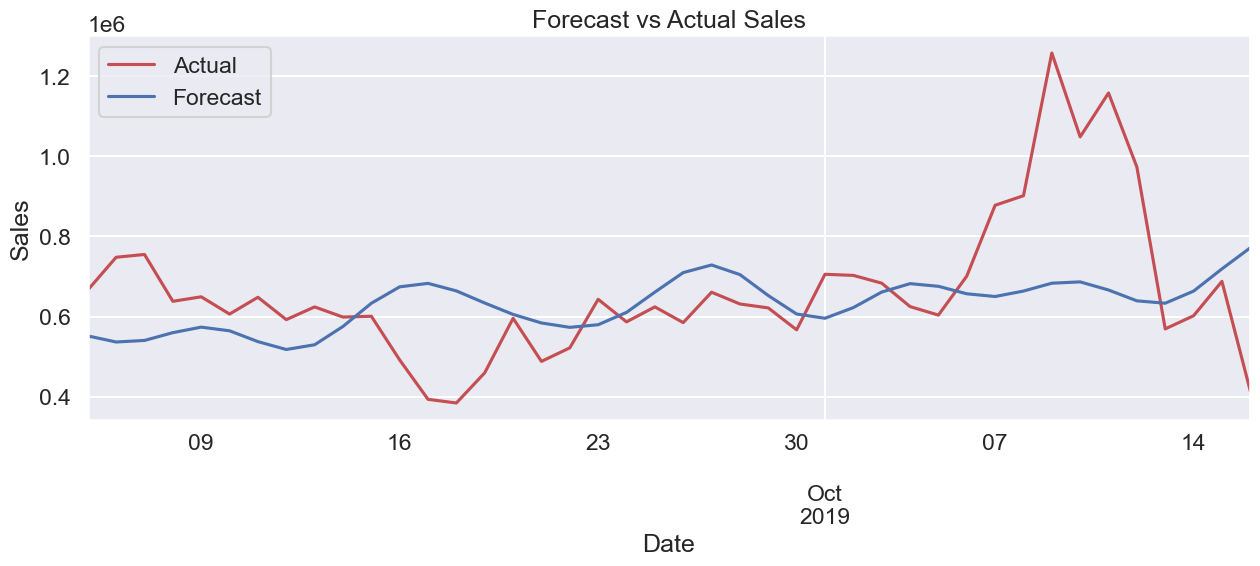

In [76]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(18, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Actual', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast vs Actual Sales')